In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
dat=load_iris()

In [3]:
df=pd.DataFrame(data=dat.data,columns=dat.feature_names)
df_targets=dat.target

In [4]:
X=df
y=df_targets
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test ,y_train, y_test  = train_test_split(X,y, random_state=42,test_size=0.20,stratify=y, shuffle=True)

In [5]:
class LDA_:
    def __init__(self,n_components=None):
        self.n_components=n_components
        self.W=None
        self.classes=None
    def fit(self,X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.classes = np.unique(y_train)
        
        # get overall mean
        overall_mean= np.mean(X_train,axis=0)
        #then get mean for each class 
        means_={}
        for c in self.classes:
            means_[c] = np.mean(X_train[y_train==c],axis=0)  

        # Then get Within-class matrix SW
        S_W = np.zeros((X_train.shape[1], X_train.shape[1]))
        for c in self.classes:
            diff=(X_train[y_train==c] - means_[c]).T
            S_W += diff @ diff.T  # like np.dot()            

        # Then get Between-class matrix SB
        S_B = np.zeros((X_train.shape[1], X_train.shape[1]))
        for c in self.classes:
            # n_c number of samples per class 
            n_c = X_train[y_train==c].shape[0]
            mean_diff=(means_[c] - overall_mean).reshape(-1,1)
            S_B += n_c * (mean_diff @ mean_diff.T)

        # Solve generalized eigenvalue problem
        eigen_vals,eigen_vectors=np.linalg.eig(np.linalg.pinv(S_W).dot(S_B))
        
        # Sort Eigen vector values based on Eigen values
        sorted_indices=np.argsort(eigen_vals)[::-1]
        eigen_vectors=eigen_vectors[:,sorted_indices]

        # Use top component for 1D projection
        # we use number of components equal no_classes-1
        if self.n_components is None:
            self.n_components = len(self.classes) - 1
            
        self.W = eigen_vectors[:, :self.n_components]


    def predict(self,X_test):
        # Project training and test data
        X_lda_train = self.X_train @ self.W
        X_lda_test = X_test @ self.W

        # get mean for each class after projection for training 
        proj_class_means={}
        for c in self.classes:
            proj_class_means[c] = np.mean(X_lda_train[y_train==c],axis=0)
################################
        # new we use Euclidean distance for multi-dimensional w
        distances={}
        for cls , mean in proj_class_means.items():
            distances[cls]=np.linalg.norm(X_lda_test - mean, axis=1)
        #####
        res=pd.DataFrame([distances[c] for c in distances])
        res_final=np.argmin(res,axis=0)
        return res_final
############################################
        # # old
        # distances = {}
        # for cls, mean in proj_class_means.items():
        #     distances[cls] = np.abs(X_lda_test - mean)
            
        # res=pd.DataFrame(np.hstack([distances[c] for c in distances] ))
        # res_final=np.argmin(res,axis=1)
        # return res_final
####################################################


    def fit_transform(self,X_train,y_train):
        self.fit(X_train,y_train)
        return self.predict(X_train)


In [6]:
clf=LDA_(1)

In [7]:
y_train_res=clf.fit_transform(X_train,y_train)

In [8]:
pred=clf.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score
print('Train Accuracy',accuracy_score(y_train_res, y_train))
print('Test Accuracy',accuracy_score(pred, y_test))

Train Accuracy 0.9833333333333333
Test Accuracy 1.0


## Plotting classes

In [10]:
X_test_proj = X_test @ clf.W

In [11]:
classes=clf.classes

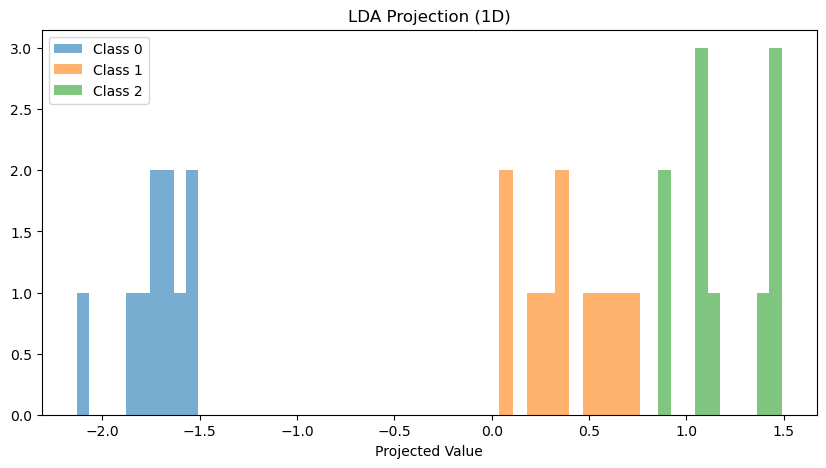

In [12]:
plt.figure(figsize=(10, 5))
for c in classes:
    plt.hist(X_test_proj[y_test == c], bins=10, alpha=0.6, label=f"Class {c}")
plt.title("LDA Projection (1D)")
plt.xlabel("Projected Value")
plt.legend()
plt.show()